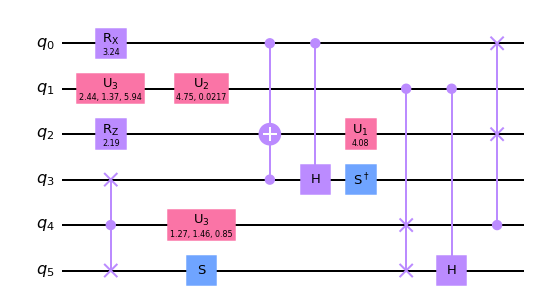

In [10]:
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import Operator
from sympy import Matrix
import sys  
sys.path.insert(0, '/Users/valerio/Documents/project_IBM_01/IBM_git/lib')
import utilities

circ = random_circuit(num_qubits = 6, depth = 4, measure=True)
circ.remove_final_measurements()
circ.draw(output='mpl')

In [11]:
Matrix(Operator(circ))

Matrix([
[ 0.0211028141554445 + 0.0166932682544324*I,    -0.332226259951844 + 0.419984206475601*I,     0.0133276552809552 - 0.02704399143766*I,     0.538224390368723 + 0.265244468634445*I,                                          0,                                          0,                                           0,                                           0,                                          0,                                           0,                                           0,                                           0,                                         0,                                            0,                                           0,                                           0, -0.00101800504822339 - 0.0197862654227065*I,     0.393782503198848 - 0.0202601434679247*I, -0.0214379293340154 + 0.00576679011871125*I,    -0.114769563626822 - 0.426653605225612*I,                                           0,                                           0,     

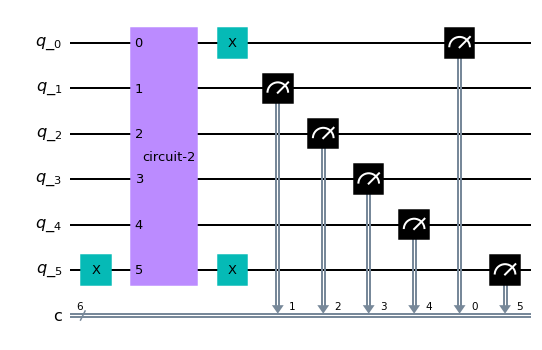

In [5]:
cal_circ, state_label = utilities.get_calibration_circuits(circ, method="NIC", eigenvector="100000")
cal_circ[1].draw(output="mpl")